In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
import sys
from pathlib import Path
import json

In [2]:
matrices_path = Path("./matrices")

fig_width_pt = 233.1  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = np.array([fig_width,fig_height])
fig_path = Path("latex")

plt.rc('text', usetex=True)

def savefig(fig, path, transparent=True, dpi=196):
    fig.savefig(fig_path / path, dpi=dpi, transparent=transparent, bbox_inches='tight') 

In [3]:
%matplotlib notebook
%matplotlib notebook

# Raw

In [10]:
fg = np.fromfile(matrices_path / "egex_fg.bin", dtype="float32").reshape((-1, 2))
bg = np.fromfile(matrices_path / "egex_bg.bin", dtype="float32").reshape((-1, 2))
nbins = 1000
bins = np.linspace(0, 12000, nbins)
hfg, *_ = np.histogram2d(fg[:, 0], fg[:, 1], bins=bins)
hbg, *_ = np.histogram2d(bg[:, 0], bg[:, 1], bins=bins)
del fg, bg
mat = hfg - hbg
mid = bins + (bins[1]-bins[0])/2
mid = mid[:-1]
raw = om.Matrix(values=mat.T, Eg=mid, Ex=mid)

<IPython.core.display.Javascript object>


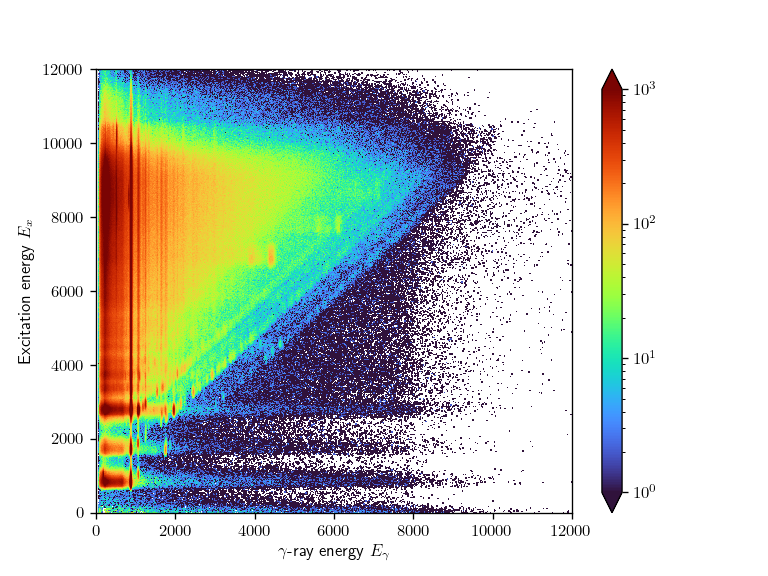

(<matplotlib.collections.QuadMesh at 0x7fcc5c542cd0>,
 <Figure size 640x480 with 2 Axes>)

In [11]:
raw.plot(cmap='turbo', vmin=1, vmax=1e3)

<IPython.core.display.Javascript object>


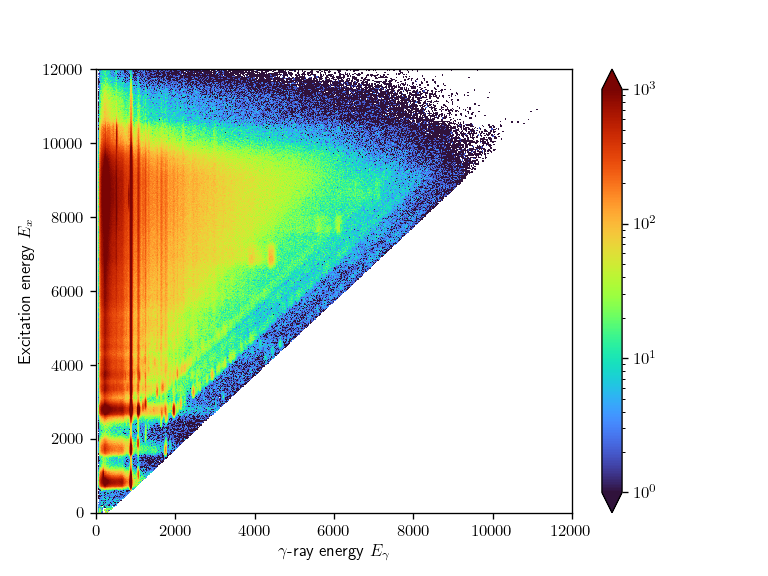

(<matplotlib.collections.QuadMesh at 0x7fcc5e6ebc70>,
 <Figure size 640x480 with 2 Axes>)

In [8]:
raw.cut_diagonal(E1=(1800, 1510), E2=(7000, 6721))
raw.plot(cmap='turbo', vmin=1, vmax=1e3)

In [20]:
logger = om.introspection.get_logger('response', 'INFO')
# Response functions
folderpath = matrices_path / "oscar2017_scale1.15"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )

# Magne recommends 1/10 of the actual resolution for unfolding purposes
response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)

2020-04-14 15:02:24,991 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
2020-04-14 15:02:56,948 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.


In [13]:
R_ompy_view.plot(title="Response matrix",# vmin=5e-5, vmax=5e-1,
                 scale="log");

In [21]:
R_ompy_view.plot_projection(axis='Eg', Emin=1330, Emax=1330)

In [53]:
raw.fill_and_remove_negative(window_size=2)
raw.save(matrices_path / "raw.npy")

# Unfolding

In [11]:
# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive = raw.copy()
raw_positive.fill_and_remove_negative(window_size=2)

# With compton subtraction and all tweaks
unfolder= om.Unfolder(response=R_ompy_unf, num_iter=10)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
#unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
#                                    "de": 1.3, "511": 0.9}
unfolded = unfolder(raw_positive)

In [12]:
raw_positive.plot(cmap = 'turbo', vmin=1)
unfolded.plot(cmap = 'turbo', vmin=1);

In [13]:
unfolded.save(matrices_path / "unfolded.npy")

## Study effect of parameters

In [2]:
from study import Study
import study

In [3]:
case = Study()

In [4]:
fwhms = [5, 10, 15, 20, 25, 28, 30, 33, 35, 40, 45, 50, 60]
numiters = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
miniter = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for fwhm in fwhms:
    for numiter in numiters:
        print(f'fwhm = {fwhm}, n = ', numiter)
        case(fwhm=fwhm, num_iter=numiter)

fwhm = 5, n =  10
Running raw again
True
making response with fwhm 30 and bins 1000
2020-04-13 17:41:43,187 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
2020-04-13 17:42:19,958 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 7 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 7 7 6 6 5 5 5 5 5 3 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 5 5 6 7 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 8 7 7 6 6 6 5 5 5 5 4 5 4 4 4 4 4 5 4
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 6 6 6 6 7 7 8 8 8 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 

fwhm = 5, n =  40
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 17 17 17 17 17
 17 17 16 16 16 16 15 15 15 15 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9 10 10 11 11 12 12 12 12 13 13 12
 13 13 13 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  7  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  8  8  8  9  9  9  9
 11 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 17
 16 16 15 15 14 14 14 13 13 13 12 13 12 11 11 10 10 10 10 10 10  9 10 10
 11 11 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 13 13 12
 12 13 12 12 11 11 11 11 12 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 13

fwhm = 5, n =  70
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 17 17 17 17 17
 17 17 16 16 16 16 15 15 15 15 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9 10 10 11 11 12 12 12 12 13 13 12
 13 13 13 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  7  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  8  8  8  9  9  9  9
 11 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 17
 16 16 15 15 14 14 14 13 13 13 12 13 12 11 11 10 10 10 10 10 10  9 10 10
 11 11 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 13 13 12
 12 13 12 12 11 11 11 11 12 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 13

fwhm = 5, n =  100
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 17 17 17 17 17
 17 17 16 16 16 16 15 15 15 15 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9 10 10 11 11 12 12 12 12 13 13 12
 13 13 13 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  7  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  8  8  8  9  9  9  9
 11 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 17
 16 16 15 15 14 14 14 13 13 13 12 13 12 11 11 10 10 10 10 10 10  9 10 10
 11 11 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 13 13 12
 12 13 12 12 11 11 11 11 12 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 10, n =  30
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 17 17 17 17 17
 17 17 16 16 16 16 15 15 15 15 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9 10 10 11 11 12 12 12 12 13 13 12
 13 13 13 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  7  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  8  8  8  9  9  9  9
 11 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 17
 16 16 15 15 14 14 14 13 13 13 12 13 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 10, n =  60
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 17 17 17 17 17
 17 17 16 16 16 16 15 15 15 15 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9 10 10 11 11 12 12 12 12 13 13 12
 13 13 13 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  7  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  8  8  8  9  9  9  9
 11 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 17
 16 16 15 15 14 14 14 13 13 13 12 13 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 10, n =  90
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 17 17 17 17 17
 17 17 16 16 16 16 15 15 15 15 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9 10 10 11 11 12 12 12 12 13 13 12
 13 13 13 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  7  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  8  8  8  9  9  9  9
 11 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 17
 16 16 15 15 14 14 14 13 13 13 12 13 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 15, n =  20
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 13 13 13 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  8  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 15, n =  50
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 13 13 13 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  8  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 15, n =  80
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 13 13 13 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  8  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 20, n =  10
False
making response with fwhm 15 and bins 1000
2020-04-13 18:06:35,641 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
2020-04-13 18:07:10,541 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 7 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 7 7 6 6 5 5 5 5 5 3 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 5 5 6 7 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 8 7 6 6 6 6 5 5 5 5 4 5 4 4 4 4 4 5 4
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 

fwhm = 20, n =  40
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 20, n =  70
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 20, n =  100
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 16 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  5  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  8  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 

fwhm = 25, n =  30
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 25, n =  60
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 25, n =  90
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 13 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 28, n =  20
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 28, n =  50
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 28, n =  80
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 30, n =  10
False
making response with fwhm 28 and bins 1000
2020-04-13 18:33:54,522 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
2020-04-13 18:34:20,051 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 7 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 7 7 6 6 5 5 5 4 5 3 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 5 5 6 7 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 7 7 6 6 6 6 5 5 5 5 4 5 4 4 4 4 4 5 4
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 

fwhm = 30, n =  40
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 30, n =  70
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 30, n =  100
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 11 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 

fwhm = 33, n =  30
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 33, n =  60
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 33, n =  90
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  6  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 35, n =  20
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 35, n =  50
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 35, n =  80
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 17 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 12 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 15 14 14 15 15 14 14 14 13 1

fwhm = 40, n =  10
False
making response with fwhm 35 and bins 1000
2020-04-13 18:57:03,561 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
2020-04-13 18:57:29,272 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 7 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 7 7 6 5 5 5 5 4 5 3 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 5 5 6 7 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 7 7 6 6 6 6 5 5 5 5 4 5 4 4 4 4 4 5 4
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 

fwhm = 40, n =  40
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 14 14 14 15 15 14 14 14 13 1

fwhm = 40, n =  70
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 14 14 14 15 15 14 14 14 13 1

fwhm = 40, n =  100
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 14 14 14 15 15 14 14 14 13 

fwhm = 45, n =  30
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 15 16 17 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 14 14 14 15 14 14 14 14 13 1

fwhm = 45, n =  60
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 15 16 17 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 14 14 14 15 14 14 14 14 13 1

fwhm = 45, n =  90
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 15 16 17 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 14 14 14 15 14 14 14 14 13 1

fwhm = 50, n =  20
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 14 14 14 15 14 14 14 14 13 1

fwhm = 50, n =  50
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 14 14 14 15 14 14 14 14 13 1

fwhm = 50, n =  80
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  8  9 11 12 13 14 15 15 16 16 17 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 15 14 14 14 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  7  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  5  5  6  7  8  9  9 10 11 11 12 12 12 12 13 13 12
 12 13 12 12 12 12 12 12 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 17 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 13 13 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 13 14 14 14 14 14 15 15 14
 15 14 14 14 15 14 14 14 14 13 1

fwhm = 60, n =  10
False
making response with fwhm 50 and bins 1000
2020-04-13 19:20:40,193 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
2020-04-13 19:21:06,145 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 7 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 7 6 6 5 5 5 5 4 5 3 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 5 5 6 7 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 7 7 6 6 6 6 5 5 5 5 4 5 4 4 4 4 4 5 4
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 

fwhm = 60, n =  40
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  7  9 11 12 13 14 14 15 15 16 16 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 14 14 14 13 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  6  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  3  5  5  6  7  8  9  9 10 11 11 12 12 12 12 12 12 12
 12 13 12 12 12 12 12 11 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 16 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 12 12 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 12 13 14 14 14 13 14 14 14
 14 14 14 14 14 14 14 13 14 13 1

fwhm = 60, n =  70
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  7  9 11 12 13 14 14 15 15 16 16 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 14 14 14 13 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  6  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  3  5  5  6  7  8  9  9 10 11 11 12 12 12 12 12 12 12
 12 13 12 12 12 12 12 11 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 16 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 12 12 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 12 13 14 14 14 13 14 14 14
 14 14 14 14 14 14 14 13 14 13 1

fwhm = 60, n =  100
[ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  5  7  7  9 11 12 13 14 14 15 15 16 16 16 16 17 17 17 17
 17 17 16 16 16 16 15 15 14 14 14 13 13 13 13 12 12 12 11 11 10 10  9  9
  8  8  7  6  6  5  5  5  5  4  5  3  4  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  3  5  5  6  7  8  9  9 10 11 11 12 12 12 12 12 12 12
 12 13 12 12 12 12 12 11 12 11 11 11 10 10 10  9 10  9  9  9  8  8  7  7
  6  6  6  6  5  5  5  5  4  5  4  4  4  4  4  5  4  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  7  7  7  8  8  9  9  9  9
 10 11 12 12 13 14 14 15 15 16 16 16 17 17 17 17 17 17 17 17 17 16 16 16
 16 16 15 15 14 14 13 13 13 13 12 12 12 11 11 10 10 10 10 10 10  9 10 10
 11 10 11 11 11 12 12 12 13 13 12 12 13 13 13 13 13 13 12 13 12 12 13 12
 12 12 12 11 11 11 11 11 11 12 12 11 12 12 12 12 13 14 14 14 13 14 14 14
 14 14 14 14 14 14 14 13 14 13 

In [28]:
(study.unfolded @ study.R_ompy).plot(vmin=1)

(<matplotlib.collections.QuadMesh at 0x7f2edd2ab310>,
 <Figure size 640x480 with 2 Axes>)

In [ ]:
errors = study.plot("studies/data.json", 1)

loaded


# Remove contaminants

In [21]:
mona_lisa = om.Matrix(path=matrices_path / "unfolded.npy")
painter = om.Painter(mona_lisa, vmin=1, vmax=2e3)

Manually paint over the contaminants, saving the polygons used for the
ensemble.

In [22]:
paint = painter.get_paint()
paint.save("paint")

(<matplotlib.collections.QuadMesh at 0x7f5416d6f190>,
 <Figure size 640x480 with 2 Axes>)

In [7]:
mona_lisa.plot(vmin=1)

(<matplotlib.collections.QuadMesh at 0x7f43582e3b20>,
 <Figure size 640x480 with 2 Axes>)

In [15]:
mona_lisa.save(matrices_path / "retouched.npy")

# First Generation

In [9]:
mona_lisa = om.Matrix(matrices_path / path="retouched.npy")
firstgen = om.FirstGeneration()
primary = firstgen(mona_lisa)

In [7]:
primary.plot(cmap='turbo', vmin=1)

(<matplotlib.collections.QuadMesh at 0x7f41ae1751f0>,
 <Figure size 640x480 with 2 Axes>)

In [5]:
primary.save(matrices_path / "firstgen.npy")

## What happens if contaminants are not removed

In [8]:
untouched = om.Matrix(path="unfolded_1000.npy")
firstgen = om.FirstGeneration()
primary = firstgen(untouched)
primary.save("firstgen_untouched.npy")

# Shape

Bin width:  50.0


<IPython.core.display.Javascript object>


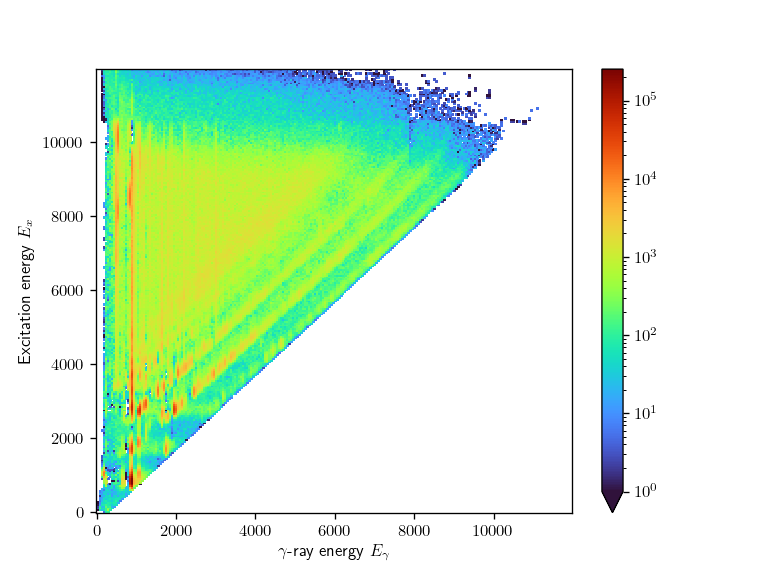

(<matplotlib.collections.QuadMesh at 0x7f35194a17c0>,
 <Figure size 640x480 with 2 Axes>)

In [99]:
mat = om.Matrix(path="firstgen.npy")
mat = mat.rebin(axis='Ex', binwidth=50, inplace=False).rebin(axis='Eg', binwidth=50, inplace=False)
print("Bin width: ", mat.Ex[1]-mat.Ex[0])
mat.plot(vmin=1)

<IPython.core.display.Javascript object>


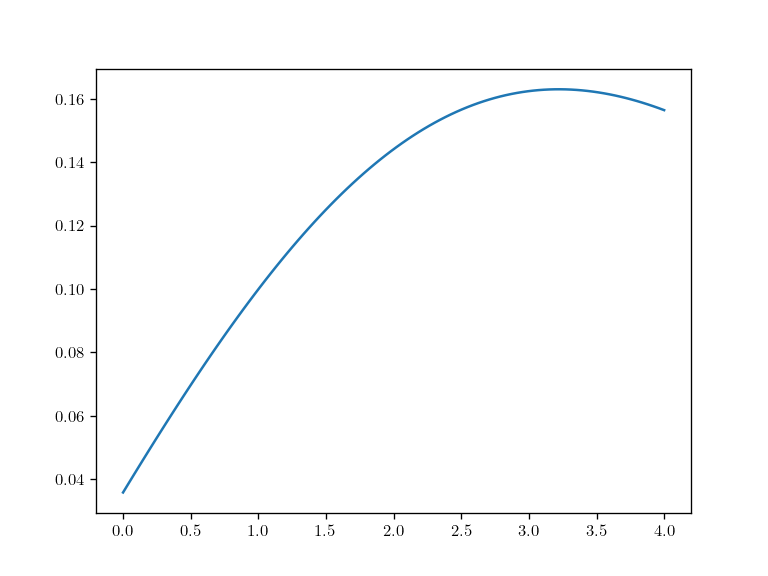

[3.72063023]


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35197575b0>)

In [100]:
pars = {"mass":70, "NLDa":9.311, "Eshift":0.876, 'Pa_prime':  2.486,
        "Sn": 9.2184, "sigma2_disc":[1.5, 3.6]}
spf = om.SpinFunctions(Ex=[6], J=np.linspace(0, 4, 100), model='EB05', pars=pars)
spf.plot()

<IPython.core.display.Javascript object>


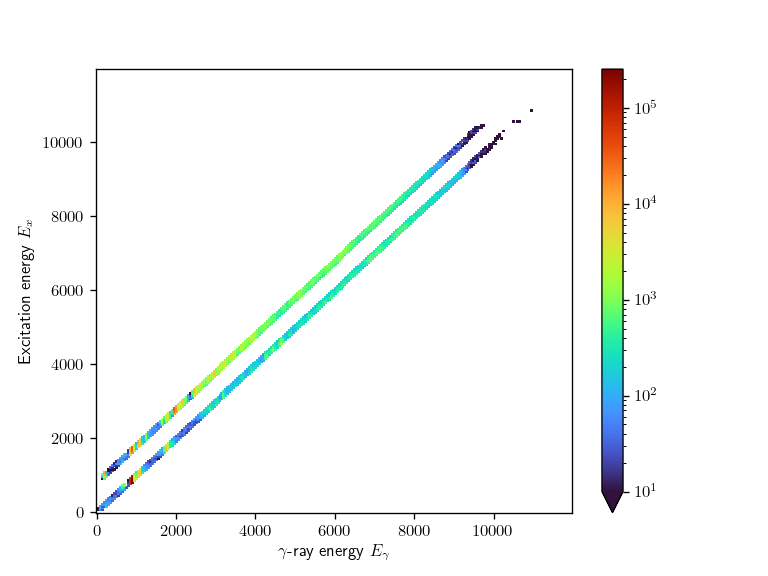

<IPython.core.display.Javascript object>


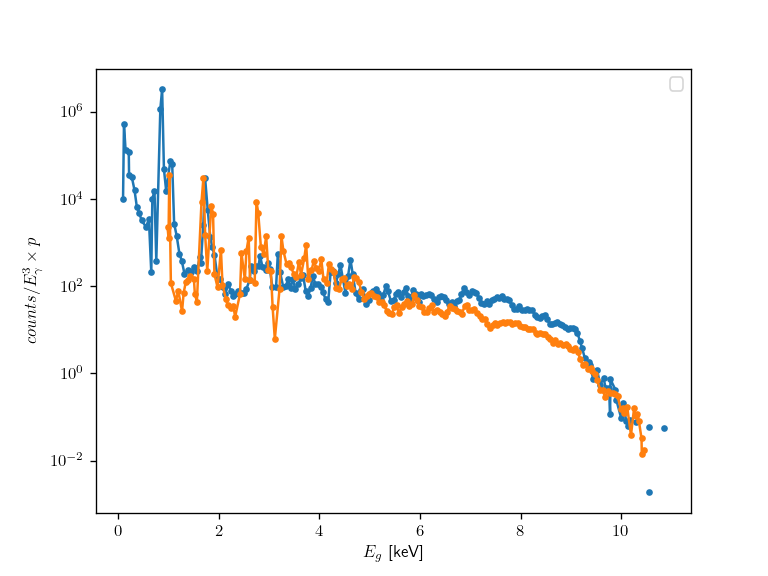

No handles with labels found to put in legend.


Ratio: nan


<IPython.core.display.Javascript object>


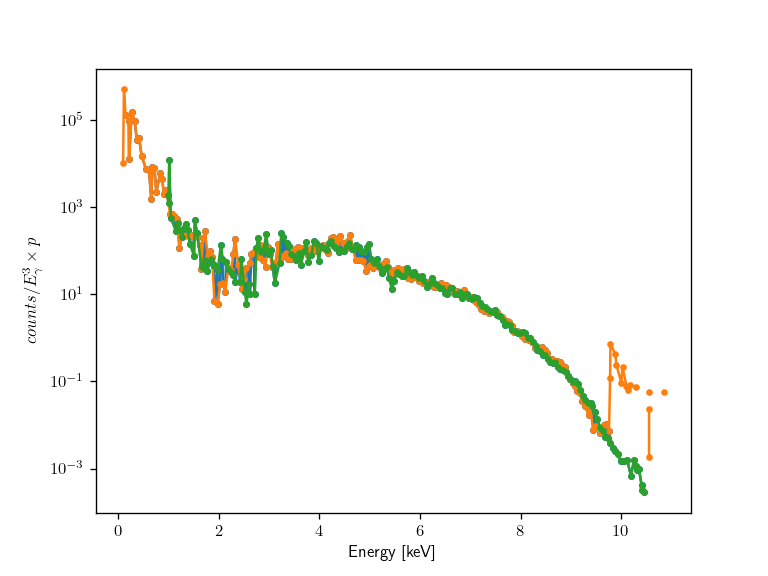

No handles with labels found to put in legend.


In [106]:
#mat = mat.rebin(axis=0, factor=2, inplace=False).rebin(axis=0, factor=2, inplace=False)
log = om.introspection.get_logger('shape', 'INFO')
shape = om.Shape(mat)
shape.spinmodel = spf
shape.add_diagonal(spin=0, parity=+1, thickness=5)
shape.add_diagonal(spin=2, parity=+1, thickness=5, points=[(1975, 2800)])
#shape.add_diagonal(spin=0, parity=+1, thickness=5, points=[(1254, 2953.7)])
shape.plot_diagonals(vmin=1e1)
shape.plot_unsewed(scale='linear')
#gsf_lin = shape.compute_gsf(kind='linear')
shape.compute_gsf(kind='log')
shape.plot()
#slope = shape.fit([5500, 9000])
#print("Slope = ", slope)
#fig, ax = shape.plot(kind='step', scale='log', linewidth=1)
#gsf_lin.plot(ax=ax, kind='step', scale='log', label='Linear sew')
ax.legend()


In [21]:
mat.plot(vmin=1e1)

(<matplotlib.collections.QuadMesh at 0x7fc4c30d7790>,
 <Figure size 640x480 with 2 Axes>)

In [178]:
peak = om.PeakSelector(mat, vmin=1e1)

AttributeError: module 'ompy' has no attribute 'PeakSelector'

# Ensemble Generation

In [1]:
# Load matrices
raw = om.Matrix(path=matrices_path / 'raw.npy')

# Make response
logger = om.introspection.get_logger('response', 'INFO')
folderpath = matrices_path / "oscar2017_scale1.15"
fwhm_abs = 30 # (30/1330 = 2.25% )
response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(raw.Eg, fwhm_abs=fwhm_abs, return_table=True)
R_ompy_unf, R_tab_unf = response.interpolate(raw.Eg, fwhm_abs=fwhm_abs/10, return_table=True)

# Make unfolder
unfolder= om.Unfolder(response=R_ompy_unf, num_iter=50)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf

# Make firstgen
firstgen = om.FirstGeneration()
paint = om.Paint(path=matrices_path / "paint")

2020-05-01 11:06:37,730 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.


KeyboardInterrupt: 

In [25]:
logger = om.introspection.get_logger('ensemble', 'DEBUG')

ensemble = om.Ensemble(raw=raw)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
ensemble.action_unfolded = paint
ensemble.generate(20, regenerate=True)

2020-04-30 12:22:01,835 - ompy.ensemble - INFO - Start normalization of 20 matrices with 1 cpus


2020-04-30 12:22:01,865 - ompy.ensemble - INFO - Generating 0
2020-04-30 12:22:01,866 - ompy.ensemble - DEBUG - Generating raw ensemble 0
2020-04-30 12:22:01,868 - ompy.ensemble - DEBUG - (Re)generating saved_run/normalizers/raw_0.npy using poisson process
2020-04-30 12:22:01,935 - ompy.ensemble - DEBUG - [Seed check] Raw sum 44199847
2020-04-30 12:22:01,937 - ompy.ensemble - DEBUG - Unfolding raw 0
2020-04-30 12:22:01,938 - ompy.ensemble - DEBUG - Unfolding matrix
2020-04-30 12:22:49,200 - ompy.ensemble - DEBUG - Performing first generation on unfolded 0
2020-04-30 12:22:49,202 - ompy.ensemble - DEBUG - Calculating first generation matrix
2020-04-30 12:23:05,466 - ompy.ensemble - INFO - Generating 1
2020-04-30 12:23:05,475 - ompy.ensemble - DEBUG - Generating raw ensemble 1
2020-04-30 12:23:05,477 - ompy.ensemble - DEBUG - (Re)generating saved_run/normalizers/raw_1.npy using poisson process
2020-04-30 12:23:05,570 - ompy.ensemble - DEBUG - [Seed check] Raw sum 44204312
2020-04-30 12:2

2020-04-30 12:33:28,000 - ompy.ensemble - DEBUG - Unfolding matrix
2020-04-30 12:34:08,727 - ompy.ensemble - DEBUG - Performing first generation on unfolded 12
2020-04-30 12:34:08,728 - ompy.ensemble - DEBUG - Calculating first generation matrix
2020-04-30 12:34:22,338 - ompy.ensemble - INFO - Generating 13
2020-04-30 12:34:22,341 - ompy.ensemble - DEBUG - Generating raw ensemble 13
2020-04-30 12:34:22,343 - ompy.ensemble - DEBUG - (Re)generating saved_run/normalizers/raw_13.npy using poisson process
2020-04-30 12:34:22,400 - ompy.ensemble - DEBUG - [Seed check] Raw sum 44212943
2020-04-30 12:34:22,404 - ompy.ensemble - DEBUG - Unfolding raw 13
2020-04-30 12:34:22,405 - ompy.ensemble - DEBUG - Unfolding matrix
2020-04-30 12:35:02,959 - ompy.ensemble - DEBUG - Performing first generation on unfolded 13
2020-04-30 12:35:02,961 - ompy.ensemble - DEBUG - Calculating first generation matrix
2020-04-30 12:35:16,825 - ompy.ensemble - INFO - Generating 14
2020-04-30 12:35:16,826 - ompy.ensembl

<IPython.core.display.Javascript object>


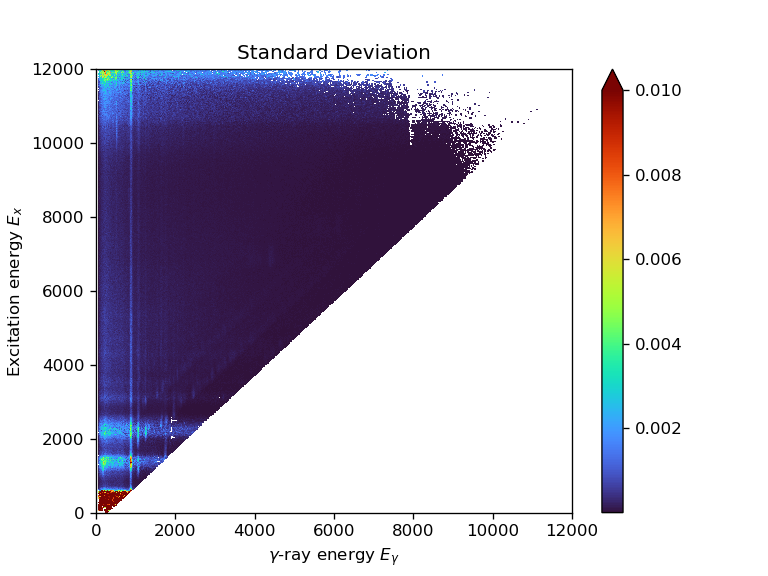

(<matplotlib.collections.QuadMesh at 0x7f02e309e970>,
 <Figure size 640x480 with 2 Axes>)

In [26]:
ensemble.std_raw_norm.plot(vmax=0.01)

In [6]:
ensemble = om.Ensemble()
ensemble.load("./saved_run/normalizers")

# Extraction 

In [13]:
#ensemble = om.LazyEnsemble(path="./saved_run/normalizers")
ensemble = om.Ensemble(path="./saved_run/normalizers")
ensemble.load()
ensemble.rebin(120.0)
print("Bin width: ", ensemble.firstgen.Ex[1] - ensemble.firstgen.Ex[0])


Bin width:  120.0


In [22]:
cut = om.Action().trapezoid(Ex_min=4475, Ex_max=9187, Eg_min=1375, Eg_max=9187+300)
extractor = om.Extractor()
extractor.trapezoid = cut

<IPython.core.display.Javascript object>


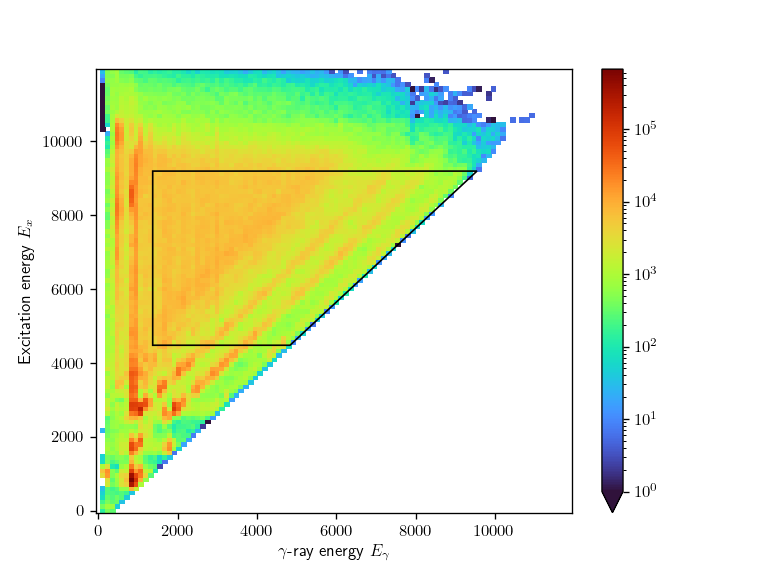

In [23]:
_, ax, _ = ensemble.firstgen.plot(vmin=1)
om.Cut(ensemble.firstgen, Ex_min=4475, Ex_max=9187,
       Eg_min=1375, Eg_max=9187+300).plot(ax)

In [20]:
logger = om.introspection.get_logger('extractor', 'DEBUG')

Extracting from a single example to see product

2020-05-14 09:14:31,267 - ompy.extractor - DEBUG - Copying std
2020-05-14 09:14:31,268 - ompy.extractor - DEBUG - Using std. (Assuming from normalized ensemble)
2020-05-14 09:14:31,269 - ompy.extractor - DEBUG - Normalizing matrix
2020-05-14 09:14:31,270 - ompy.extractor - DEBUG - Verifying step sizes
2020-05-14 09:14:31,272 - ompy.extractor - DEBUG - Creating nld energy array
2020-05-14 09:14:31,273 - ompy.extractor - DEBUG - Setting resolution
2020-05-14 09:14:31,274 - ompy.extractor - DEBUG - Getting initial values
2020-05-14 09:14:31,275 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-05-14 09:14:31,276 - ompy.extractor - INFO - Minimizing
2020-05-14 09:14:33,007 - ompy.extractor - INFO - Optimization terminated successfully.
2020-05-14 09:14:33,008 - ompy.extractor - INFO -          Current function value: 26604.316776
2020-05-14 09:14:33,009 - ompy.extractor - INFO -          Iterations: 5
2020-05-14 09:14:33,010 - ompy.extractor - INFO -          

<IPython.core.display.Javascript object>


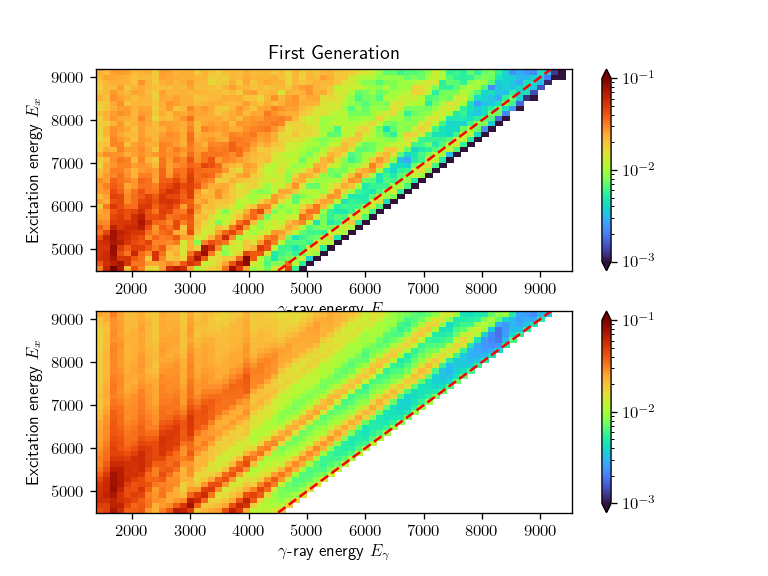

In [24]:
mat = ensemble.get_firstgen(0).copy()
std = ensemble.std_firstgen_norm.copy()
cut.act_on(mat)
cut.act_on(std)
_, _, product = extractor.decompose(mat, std, product=True)
fig, ax = plt.subplots(2,1)
mat.normalize('Ex')
mat.plot(ax=ax[0], scale="log", vmin=1e-3, vmax=1e-1)
product.plot(ax=ax[1], scale="log", vmin=1e-3, vmax=1e-1)

x = np.linspace(*ax[0].get_ylim())
ax[0].plot(x, x, "r--", label="E_x = E_g")
ax[1].plot(x, x, "r--", label="E_x = E_g")

In [25]:
extractor.extract_from(ensemble, regenerate=True)

2020-05-14 09:14:55,822 - ompy.extractor - DEBUG - Extracting from 0
2020-05-14 09:14:55,823 - ompy.extractor - DEBUG - Getting matrix and std from ensemble.
2020-05-14 09:14:55,826 - ompy.extractor - DEBUG - Decomposing
2020-05-14 09:14:55,829 - ompy.extractor - DEBUG - Copying std
2020-05-14 09:14:55,831 - ompy.extractor - DEBUG - Using std. (Assuming from normalized ensemble)
2020-05-14 09:14:55,831 - ompy.extractor - DEBUG - Normalizing matrix
2020-05-14 09:14:55,833 - ompy.extractor - DEBUG - Verifying step sizes
2020-05-14 09:14:55,834 - ompy.extractor - DEBUG - Creating nld energy array
2020-05-14 09:14:55,835 - ompy.extractor - DEBUG - Setting resolution
2020-05-14 09:14:55,836 - ompy.extractor - DEBUG - Getting initial values
2020-05-14 09:14:55,837 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-05-14 09:14:55,838 - ompy.extractor - INFO - Minimizing
2020-05-14 09:14:57,652 - ompy.extractor - INFO - Optimization terminated successfully.
2020-05

2020-05-14 09:15:07,947 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-05-14 09:15:07,948 - ompy.extractor - INFO - Minimizing
2020-05-14 09:15:09,850 - ompy.extractor - INFO - Optimization terminated successfully.
2020-05-14 09:15:09,850 - ompy.extractor - INFO -          Current function value: 26229.385366
2020-05-14 09:15:09,854 - ompy.extractor - INFO -          Iterations: 5
2020-05-14 09:15:09,855 - ompy.extractor - INFO -          Function evaluations: 8904
2020-05-14 09:15:09,870 - ompy.extractor - DEBUG - Extracting from 7
2020-05-14 09:15:09,871 - ompy.extractor - DEBUG - Getting matrix and std from ensemble.
2020-05-14 09:15:09,872 - ompy.extractor - DEBUG - Decomposing
2020-05-14 09:15:09,873 - ompy.extractor - DEBUG - Copying std
2020-05-14 09:15:09,875 - ompy.extractor - DEBUG - Using std. (Assuming from normalized ensemble)
2020-05-14 09:15:09,876 - ompy.extractor - DEBUG - Normalizing matrix
2020-05-14 09:15:09,877 - ompy.extractor - DE

2020-05-14 09:15:23,970 - ompy.extractor - DEBUG - Copying std
2020-05-14 09:15:23,974 - ompy.extractor - DEBUG - Using std. (Assuming from normalized ensemble)
2020-05-14 09:15:23,975 - ompy.extractor - DEBUG - Normalizing matrix
2020-05-14 09:15:23,976 - ompy.extractor - DEBUG - Verifying step sizes
2020-05-14 09:15:23,977 - ompy.extractor - DEBUG - Creating nld energy array
2020-05-14 09:15:23,978 - ompy.extractor - DEBUG - Setting resolution
2020-05-14 09:15:23,979 - ompy.extractor - DEBUG - Getting initial values
2020-05-14 09:15:23,980 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-05-14 09:15:23,981 - ompy.extractor - INFO - Minimizing
2020-05-14 09:15:25,526 - ompy.extractor - INFO - Optimization terminated successfully.
2020-05-14 09:15:25,527 - ompy.extractor - INFO -          Current function value: 26271.058607
2020-05-14 09:15:25,528 - ompy.extractor - INFO -          Iterations: 5
2020-05-14 09:15:25,530 - ompy.extractor - INFO -          

2020-05-14 09:15:36,002 - ompy.extractor - INFO -          Current function value: 25916.844852
2020-05-14 09:15:36,003 - ompy.extractor - INFO -          Iterations: 5
2020-05-14 09:15:36,003 - ompy.extractor - INFO -          Function evaluations: 8870



<IPython.core.display.Javascript object>


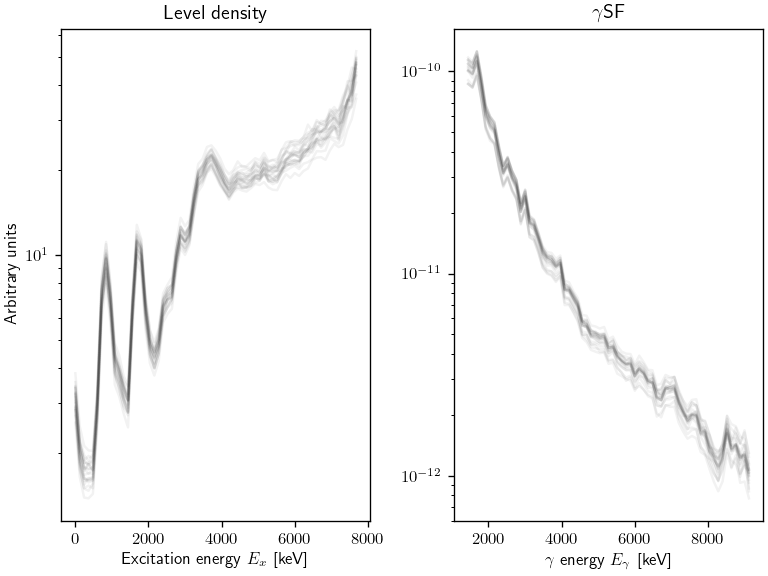

(<Figure size 640x480 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc38f44310>,
       dtype=object))

In [29]:
extractor.plot()

## Different binning

In [53]:
cut = om.Action().trapezoid(Ex_min=5000, Ex_max=9200, Eg_min=1000)
extractor = om.Extractor(path="./saved_run/extract_100")#options={'maxfev': 10, 'maxiter': 10, 'disp': True})
#extractor.method = 'Nelder-Mead'
extractor.trapezoid = cut
ensemble = om.Ensemble(path="./saved_run/normalizers")
ensemble.load()
ensemble.rebin(300)

2020-04-29 21:44:46,175 - ompy.extractor - DEBUG - Loading from saved_run/extract_100


<IPython.core.display.Javascript object>


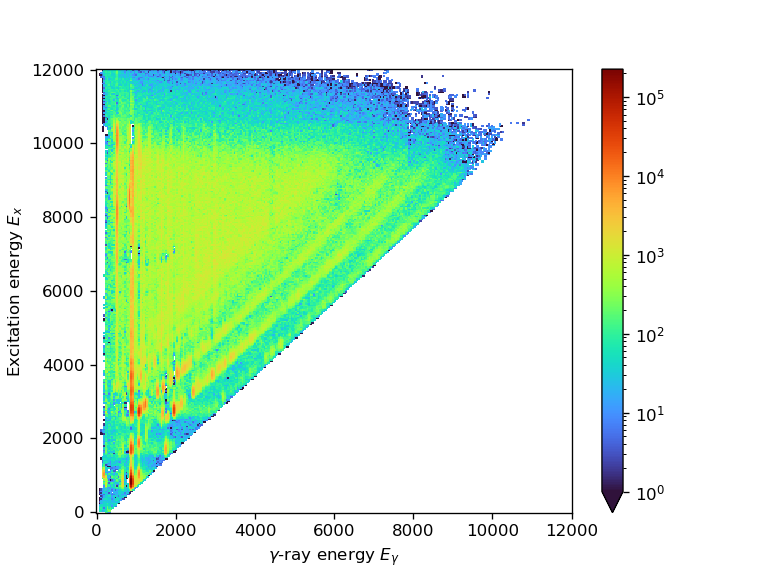

(<matplotlib.collections.QuadMesh at 0x7fef84904b50>,
 <Figure size 640x480 with 2 Axes>)

In [54]:
ensemble.firstgen.plot(vmin=1)

In [55]:
extractor.extract_from(ensemble, regenerate=True)

2020-04-29 21:45:15,464 - ompy.extractor - DEBUG - Extracting from 0
2020-04-29 21:45:15,465 - ompy.extractor - DEBUG - Getting matrix and std from ensemble.
2020-04-29 21:45:15,474 - ompy.extractor - DEBUG - Decomposing
2020-04-29 21:45:15,475 - ompy.extractor - DEBUG - Copying std
2020-04-29 21:45:15,477 - ompy.extractor - DEBUG - Using std. (Assuming from normalized ensemble)
2020-04-29 21:45:15,477 - ompy.extractor - DEBUG - Normalizing matrix
2020-04-29 21:45:15,479 - ompy.extractor - DEBUG - Verifying step sizes
2020-04-29 21:45:15,480 - ompy.extractor - DEBUG - Creating nld energy array
2020-04-29 21:45:15,481 - ompy.extractor - DEBUG - Setting resolution
2020-04-29 21:45:15,485 - ompy.extractor - DEBUG - Getting initial values
2020-04-29 21:45:15,486 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-04-29 21:45:15,487 - ompy.extractor - INFO - Minimizing
2020-04-29 21:46:22,332 - ompy.extractor - INFO - Optimization terminated successfully.
2020-04

2020-04-29 21:54:11,254 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-04-29 21:54:11,255 - ompy.extractor - INFO - Minimizing
2020-04-29 21:55:10,537 - ompy.extractor - INFO - Optimization terminated successfully.
2020-04-29 21:55:10,537 - ompy.extractor - INFO -          Current function value: 147216.550309
2020-04-29 21:55:10,538 - ompy.extractor - INFO -          Iterations: 5
2020-04-29 21:55:10,538 - ompy.extractor - INFO -          Function evaluations: 26166
2020-04-29 21:55:10,555 - ompy.extractor - DEBUG - Extracting from 7
2020-04-29 21:55:10,556 - ompy.extractor - DEBUG - Getting matrix and std from ensemble.
2020-04-29 21:55:10,558 - ompy.extractor - DEBUG - Decomposing
2020-04-29 21:55:10,558 - ompy.extractor - DEBUG - Copying std
2020-04-29 21:55:10,559 - ompy.extractor - DEBUG - Using std. (Assuming from normalized ensemble)
2020-04-29 21:55:10,560 - ompy.extractor - DEBUG - Normalizing matrix
2020-04-29 21:55:10,562 - ompy.extractor - 

2020-04-29 22:01:05,830 - ompy.extractor - DEBUG - Copying std
2020-04-29 22:01:05,831 - ompy.extractor - DEBUG - Using std. (Assuming from normalized ensemble)
2020-04-29 22:01:05,831 - ompy.extractor - DEBUG - Normalizing matrix
2020-04-29 22:01:05,833 - ompy.extractor - DEBUG - Verifying step sizes
2020-04-29 22:01:05,834 - ompy.extractor - DEBUG - Creating nld energy array
2020-04-29 22:01:05,835 - ompy.extractor - DEBUG - Setting resolution
2020-04-29 22:01:05,836 - ompy.extractor - DEBUG - Getting initial values
2020-04-29 22:01:05,837 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-04-29 22:01:05,838 - ompy.extractor - INFO - Minimizing
2020-04-29 22:02:05,417 - ompy.extractor - INFO - Optimization terminated successfully.
2020-04-29 22:02:05,417 - ompy.extractor - INFO -          Current function value: 147430.510194
2020-04-29 22:02:05,418 - ompy.extractor - INFO -          Iterations: 5
2020-04-29 22:02:05,418 - ompy.extractor - INFO -         

2020-04-29 22:07:52,844 - ompy.extractor - INFO -          Current function value: 146850.637237
2020-04-29 22:07:52,846 - ompy.extractor - INFO -          Iterations: 5
2020-04-29 22:07:52,846 - ompy.extractor - INFO -          Function evaluations: 26200



<IPython.core.display.Javascript object>


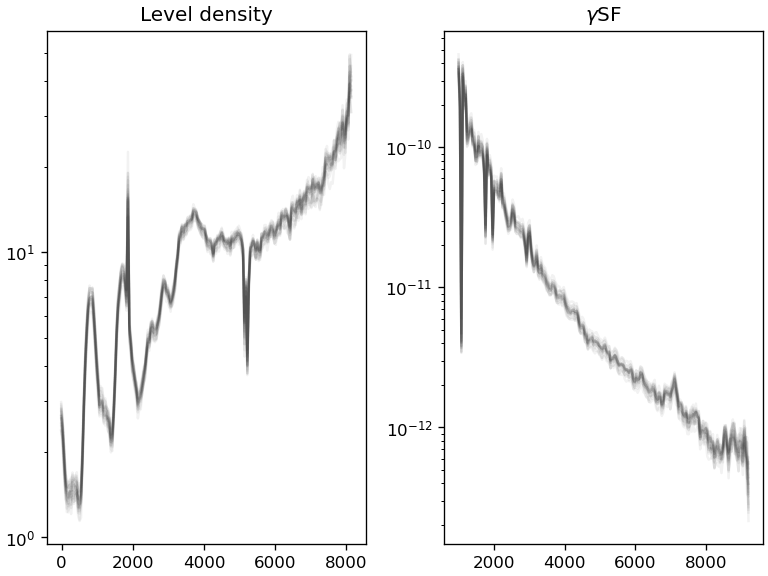

(<Figure size 640x480 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fef84c05fd0>,
       dtype=object))

In [56]:
extractor.plot(plot_mean=False)

# Normalizing

## Normalize to known data

Fetch discrete levels from NuDat.

In [33]:
nndc = om.NNDC('70zn')
nndc.save('normalization/discrete_levels.txt')
print(nndc.levels())
discrete = nndc.level_hist(nld_mean.E)
discrete.save('discrete.npy')

[   0.    884.92 1070.76 1554.   1759.16 1786.75 1957.28 2140.64 2375.
 2538.31 2665.   2693.4  2805.   2859.49 2895.1  2949.67 2954.   2978.26
 3022.   3038.15 3222.08 3235.   3246.71 3328.   3342.   3419.   3464.
 3476.68 3506.   3598.98 3634.99 3680.   3710.7  3750.   3755.4  3788.16
 3813.   3844.   3848.4  3888.   3904.   3914.   3948.   3999.   4001.46
 4016.   4061.4  4066.   4136.   4146.1  4172.   4264.5  4291.   4308.99
 4367.   4444.   4464.77 4514.27 4558.2  4588.8  4710.1  4791.7  4849.2
 4935.9  5061.3  6116.2 ]


In [4]:
extractor = om.Extractor(path="./saved_run/extraction_ensemble/")
for nld in extractor.nld:
    nld.cut_nan()
for gsf in extractor.gsf:
    gsf.cut_nan()

In [5]:
nld_mean = extractor.ensemble_nld()
nld_mean.to_MeV()
nld_mean.cut(Emin=0, inplace=True)
nld_mean.E[0] = 0.0
#fig, ax = nld_mean.plot()
#discrete.plot(ax=ax, kind='step', scale='log')

In [6]:
normlog = om.introspection.get_logger('normalizer_nld', 'DEBUG')
nldnorm = om.NormalizerNLD(nld=nld_mean, discrete='normalization/discrete_levels.txt',
                           regenerate=True)

2020-05-15 16:12:11,124 - ompy.normalizer_nld - DEBUG - Set `discrete` levels from file with FWHM 0.1


In [9]:
norm_pars = om.NormalizationParameters(name="70Zn")
norm_pars.D0 = [367, 19]  # eV
norm_pars.Sn = [9.2184, 0.001] # MeV
norm_pars.spincutModel = 'EB05'  # see eg. Guttormsen et al., 2017, PRC 96, 024313
norm_pars.spincutPars = {"mass":70, "NLDa":8.770, "Eshift":0.819,
                         "Sn": norm_pars.Sn[0], "sigma2_disc":[1.5, 3.6]}
norm_pars.Jtarget = 5/2 # A-1 nucleus

nldnorm.normalize(limit_low=[1.5, 2], limit_high=[4, 6], norm_pars=norm_pars)

2020-05-15 16:17:03,930 - ompy.normalizer_nld - INFO - 

---------
Normalizing nld #0
2020-05-15 16:17:03,932 - ompy.normalizer_nld - DEBUG - Setting NLD, convert to MeV
2020-05-15 16:17:03,956 - ompy.normalizer_nld - DEBUG - Using bounds [[0.1, 20], [0.1, 2], [0.1, 5], [-5, 5]]
2020-05-15 16:17:03,957 - ompy.normalizer_nld - DEBUG - Using spincutModel EB05
2020-05-15 16:17:03,959 - ompy.normalizer_nld - DEBUG - Using spincutPars {
    "Eshift": 0.819,
    "NLDa": 8.77,
    "Sn": 9.2184,
    "mass": 70,
    "sigma2_disc": [
        1.5,
        3.6
    ]
}
0.1297655296415412
2020-05-15 16:17:03,962 - ompy.normalizer_nld - DEBUG - NLD Sn from D0: 10000
2020-05-15 16:17:03,963 - ompy.normalizer_nld - DEBUG - Relative uncertainty: 0.3
2020-05-15 16:17:03,964 - ompy.normalizer_nld - DEBUG - NLD Sn: 10000 ± 3000
2020-05-15 16:17:04,582 - ompy.normalizer_nld - INFO - DE results:
┌────────────────────┬─────────────────────┬───────────────────┬──────────────┐
│ A                  │ α [MeV⁻¹]  

<IPython.core.display.Javascript object>


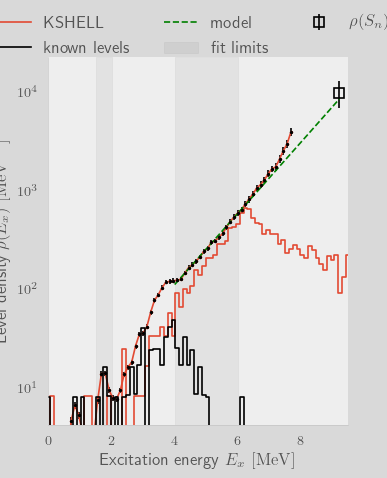

0.1297655296415412
2020-05-15 16:17:23,621 - ompy.normalizer_nld - INFO - Saving to normalization/NormalizerNLD.pkl


In [10]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(figsize = (fig_size[0], 2*fig_size[1]))
    kshell = om.Vector(path="kshell/kshell.npy")
    kshell.to_MeV()
    kshell.plot(ax=ax, kind='step', scale='log', label='KSHELL')
    nldnorm.plot(ax=ax)
    ax.set_xlim([0, 9.5])
    #savefig(fig, "nldnorm.pdf", dpi=300)
nldnorm.save(path="normalization/")

## gSF Normalization

E1 giant dipole resonance data from EXFOR

<IPython.core.display.Javascript object>


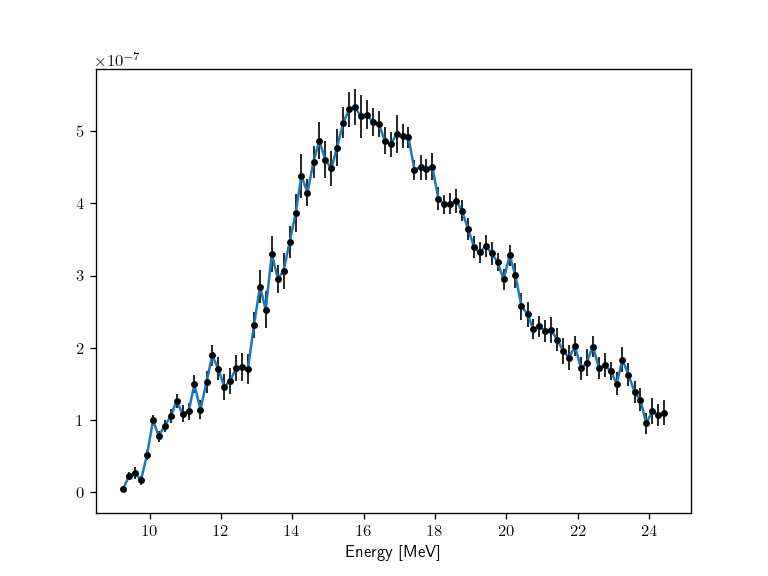

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f58b11ac6d0>)

In [14]:
def cross_section_to_MeV(cs, Eg):
    return 8.674e-8*cs/Eg

exfor = json.load(Path("normalization/exfor.json").open())
data = exfor["datasets"][0]['data']
Y, Yerr, X, _ = [np.asarray(x) for x in zip(*data)]
rel_err = Yerr/Y
Y = cross_section_to_MeV(Y, X)
Yerr = rel_err*Y
exfor = om.Vector(E=X, values=Y, std=Yerr, units='MeV')
exfor.plot()

E1 Calculations through QRPA on top of Hartree-Fock-Bogoliubov

<IPython.core.display.Javascript object>


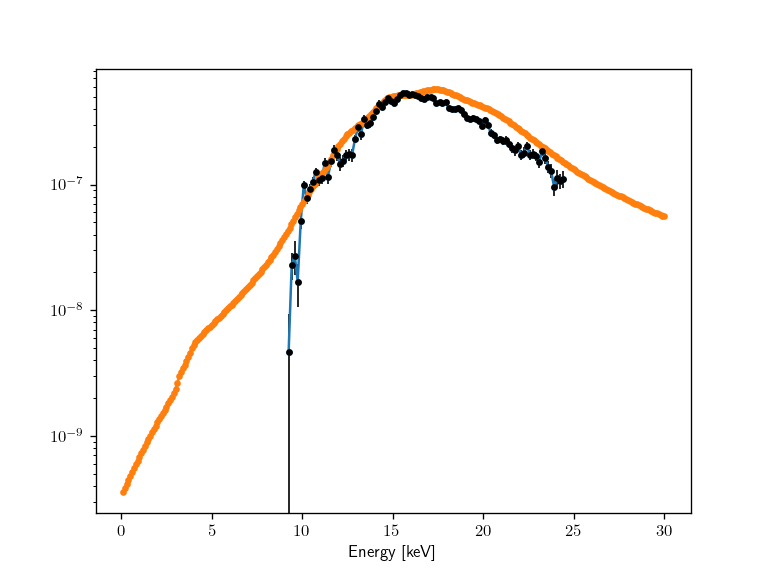

In [15]:
qrpa = np.loadtxt("normalization/Zn-70-E1-HFB-QRPA.txt", skiprows=2)
qrpa[:, 1] *= 8.6737e-8
qrpa = om.Vector(E=qrpa[:, 0], values=qrpa[:, 1])
fig, ax = exfor.plot()
qrpa.plot(ax=ax)
ax.set_yscale('log')

M1 Strength function from KSHELL

<IPython.core.display.Javascript object>


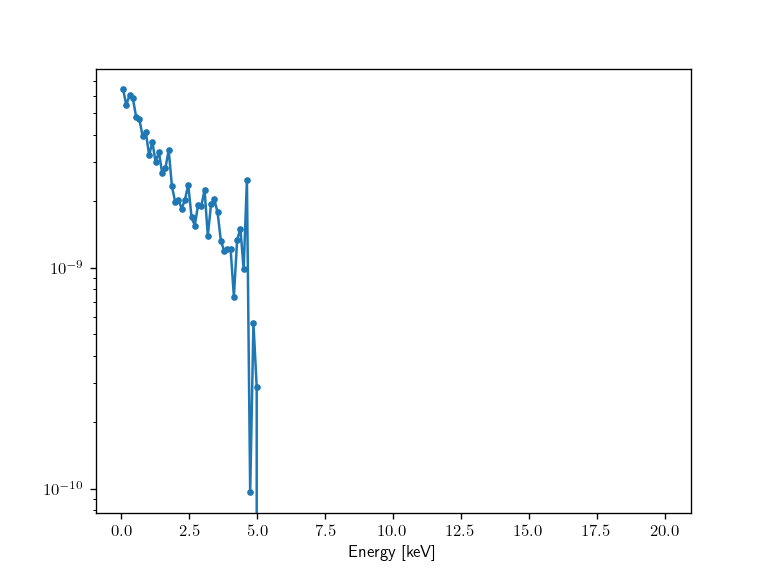

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f58b05a3ac0>)

In [16]:
gsf_M1 = om.Vector(path="kshell/gsf_kshell.npy")
gsf_M1.E /= 1e3
gsf_M1.plot(scale='log')

Theoretical sum of M1 + E1

<IPython.core.display.Javascript object>


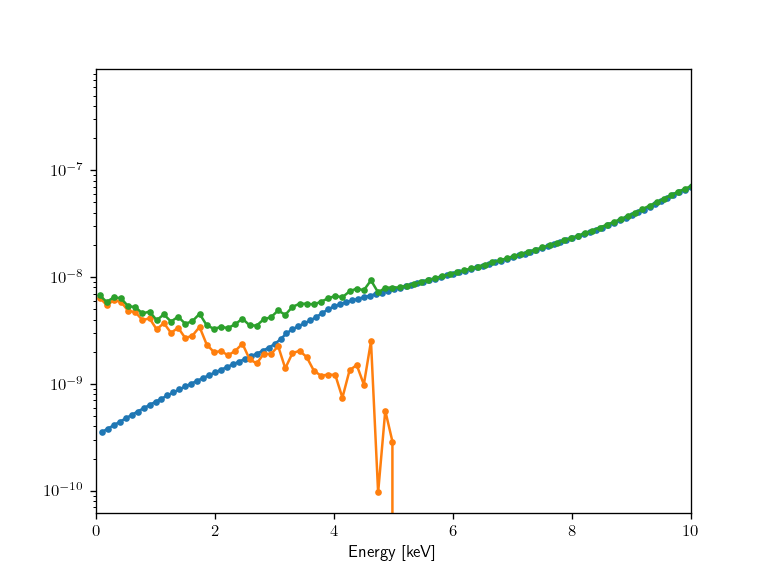

1.204200373366532


(0.0, 10.0)

In [17]:
fig, ax = qrpa.plot()
gsf_M1.plot(ax=ax)
summed = qrpa.forcefully_add(gsf_M1)
summed.plot(ax=ax)
ax.set_yscale("log")
ax.set_xlim([0, 10])

Normalize gsf to Exfor

In [36]:
gsf = extractor.ensemble_gsf()

In [59]:
normlog = om.introspection.get_logger('normalizer_gsf', 'DEBUG')
gsfnorm = om.NormalizerGSF(normalizer_nld=nldnorm, gsf=gsf,
                           regenerate=True)

# to be use for gsf normalization

norm_pars = om.NormalizationParameters(name="70Zn")
norm_pars.Gg = [380., 50.]  #meV
norm_pars.D0 = [700, 50]  # eV5
norm_pars.Sn = [9.2184, 0.001] # MeV
norm_pars.spincutModel = 'EB05'  # see eg. Guttormsen et al., 2017, PRC 96, 024313
norm_pars.spincutPars = {"mass":70, "NLDa":8.770, "Eshift":0.819, #-1.938,
                         "Sn": norm_pars.Sn[0], "sigma2_disc":[1.5, 3.6]}
norm_pars.Jtarget = 5/2 # A-1 nucleus
gsfnorm.norm_pars = norm_pars
gsfnorm.model_high.Efit = [5,9]
gsfnorm.model_low.Efit = [2, 3]


<IPython.core.display.Javascript object>


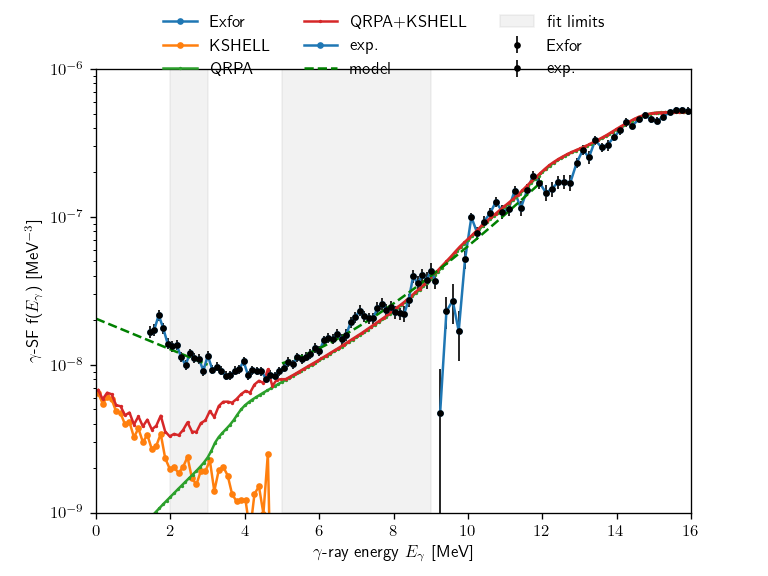

2020-05-15 16:37:24,857 - ompy.normalizer_gsf - DEBUG - Setting nld from from normalizer_nld
2020-05-15 16:37:24,870 - ompy.normalizer_gsf - DEBUG - Setting alpha from from normalizer_nld
2020-05-15 16:37:24,882 - ompy.normalizer_gsf - DEBUG - Setting nld_model from from normalizer_nld
2020-05-15 16:37:24,893 - ompy.normalizer_gsf - INFO - Normalizing #0
2020-05-15 16:37:24,894 - ompy.normalizer_gsf - DEBUG - Fitting extrapolation parameters
2020-05-15 16:37:24,927 - ompy.normalizer_gsf - DEBUG - Extrapolating low: Model model_low

Exponential scaling Exp[scale*Eg + shift]before normalization in MeV^-1
scale: float = -0.23893230598761267

Exponential shift Exp[scale*Eg + shift]before normalization
shift: float = -21.765415063554013

Minimal gamma energy to extrapolate from in MeV
Emin: Union[float, NoneType] = 0

Maximal gamma energy to extrapolate from in MeV
Emax: Union[float, NoneType] = 1.4460060060060058

Number of gamma energies to use in extrapolation
steps: int = 1001

extrapol

In [60]:
fig, ax = plt.subplots()
exfor.plot(ax=ax, label='Exfor')
gsf_M1.plot(ax=ax, label='KSHELL')
qrpa.plot(ax=ax, label='QRPA', markersize=1)
summed.plot(ax=ax, label='QRPA+KSHELL', markersize=1)
gsfnorm.normalize()
gsfnorm.plot(ax=ax, extrap_high=12)
ax.set_yscale('log')
ax.set_xlim([0, 16])
ax.set_ylim([1e-9, 1e-6])
gsfnorm.save("normalization/")

2020-05-14 09:49:35,490 - ompy.normalizer_gsf - INFO - Normalizing #0


<IPython.core.display.Javascript object>


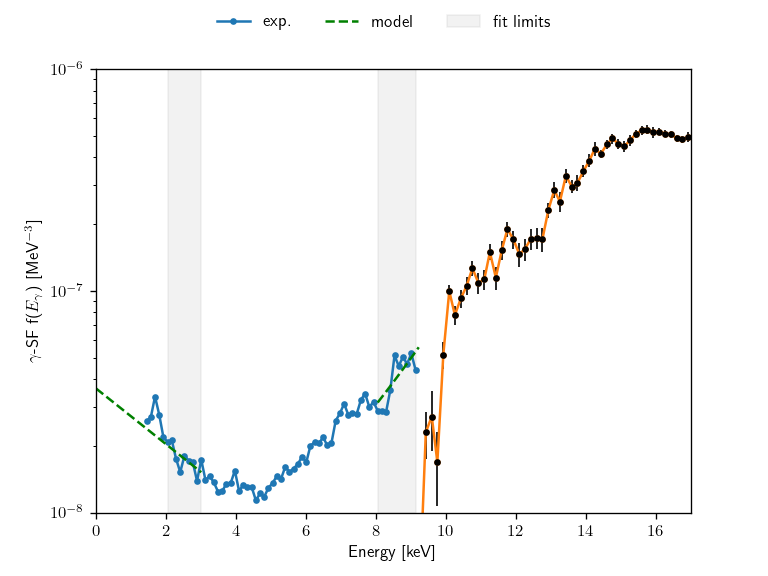

interactive(children=(SelectionRangeSlider(description='Elow', index=(5, 13), options=((1.4460060060060058, 1.…

In [55]:
gsfnorm.plot_interactive(exfor, xlim=[0, 17], ylim=[1e-8, 1e-6], scale='log')

## Simultan

In [57]:
normlog = om.introspection.get_logger('normalizer_simultan', 'INFO')
simnorm = om.NormalizerSimultan(normalizer_nld=nldnorm, normalizer_gsf=gsfnorm,
                               regenerate=True)

# running faster than the default 400 given less precise answers
# For propper calc. you may rather increase this to > 400.
simnorm.multinest_kwargs["n_live_points"] = 400

simnorm.normalize(gsf=extractor.gsf[0], nld=extractor.nld[0])

2020-05-14 10:00:52,762 - ompy.normalizer_nld - DEBUG - Using bounds [[0.1, 20], [0.1, 2], [0.1, 5], [-5, 5]]
2020-05-14 10:00:52,763 - ompy.normalizer_nld - DEBUG - Using spincutModel EB05
2020-05-14 10:00:52,764 - ompy.normalizer_nld - DEBUG - Using spincutPars {
    "Eshift": 0.819,
    "NLDa": 8.77,
    "Sn": 9.2184,
    "mass": 70,
    "sigma2_disc": [
        1.5,
        3.6
    ]
}
0.1297655296415412
2020-05-14 10:00:52,766 - ompy.normalizer_nld - DEBUG - NLD Sn from D0: 10000
2020-05-14 10:00:52,766 - ompy.normalizer_nld - DEBUG - Relative uncertainty: 0.3
2020-05-14 10:00:52,767 - ompy.normalizer_nld - DEBUG - NLD Sn: 10000 ± 3000
2020-05-14 10:00:53,806 - ompy.normalizer_nld - INFO - DE results:
┌────────────────────┬───────────┬───────────────────┬──────────────┐
│ A                  │ α [MeV⁻¹] │ T [MeV]           │ Eshift [MeV] │
╞════════════════════╪═══════════╪═══════════════════╪══════════════╡
│ 0.7984724710239993 │ 0.1       │ 2.435881414589542 │ -5.0         │
└───

<IPython.core.display.Javascript object>


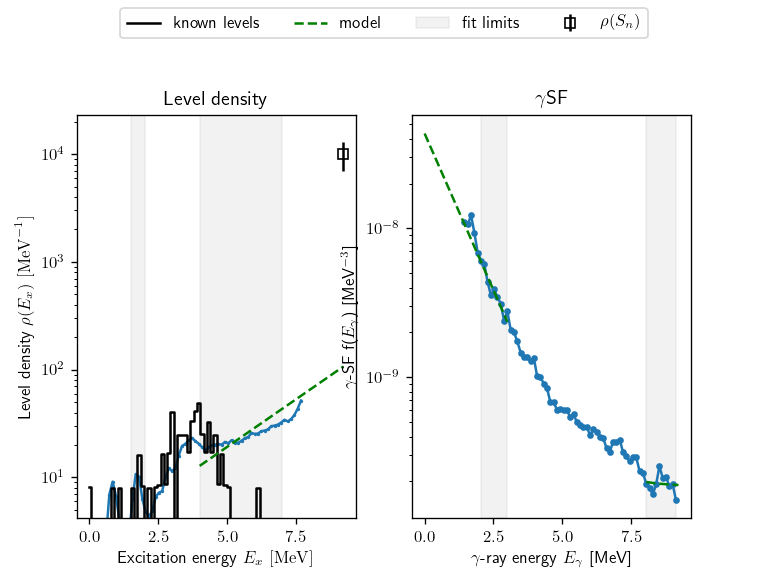

0.1297655296415412


(<Figure size 640x480 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc387411f0>,
       dtype=object))

In [58]:
simnorm.plot()

In [ ]:
ensemblenorm_sim = om.EnsembleNormalizer(extractor=extractor, normalizer_simultan=simnorm,
                                         regenerate=True)

ensemblenorm_sim.normalize()

### nldnorm.plot()

<IPython.core.display.Javascript object>


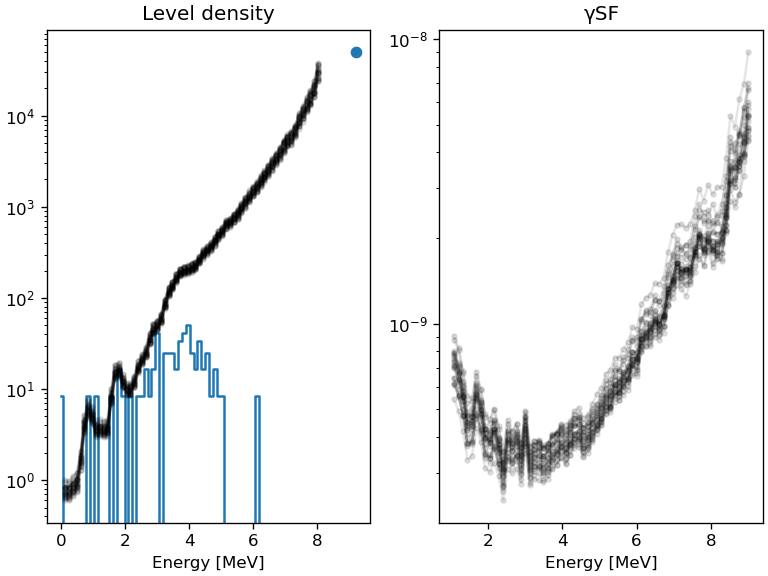

In [130]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from copy import deepcopy

nlds = deepcopy(extractor.nld)
gsfs = deepcopy(extractor.gsf)

def plot_transformed(alpha, A=1, B=1):
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    discrete.to_MeV()
    discrete.plot(ax=ax[0], kind='step')
    for nld, gsf in zip(nlds, gsfs):
        nld.to_MeV()
        gsf.to_MeV()
        nld.transform(const=A, alpha=alpha, inplace=False).plot(ax=ax[0], scale="log", color='k', alpha=1/10)
        gsf.transform(const=B, alpha=alpha, inplace=False).plot(ax=ax[1], scale="log", color='k', alpha=1/10)
    ax[0].scatter([9.2184], [49712])
    ax[0].set_title("Level density")
    ax[1].set_title("γSF")
    
plot_transformed(A=0.4, alpha=0.99)

In [180]:
norm_pars.Sn[0]

9.2184

<IPython.core.display.Javascript object>


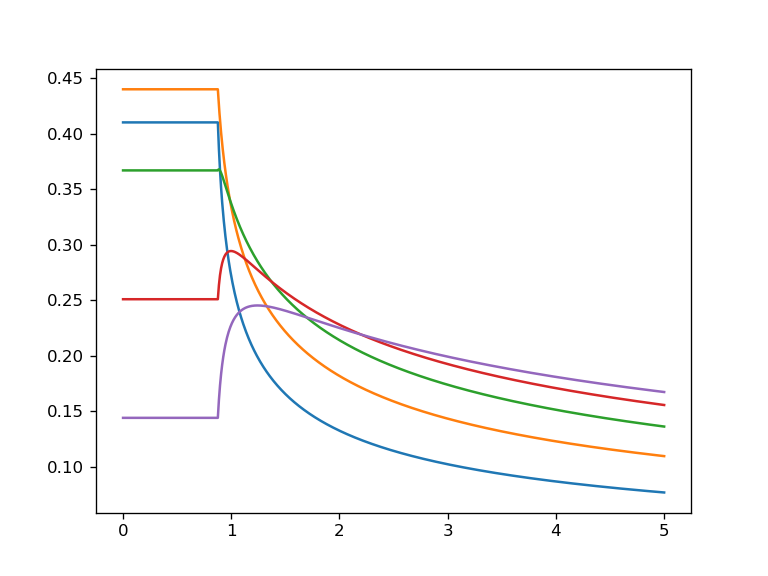

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6d8440520>)

In [172]:
Ex = nld_mean.E
Ex = np.linspace(0, 5, 1000)
pars = {"mass":70, "NLDa":9.311, "Eshift":0.876,
        "Sn": norm_pars.Sn[0], "sigma2_disc":[1.5, 3.6]}
spf = om.SpinFunctions(Ex=Ex, J=[1/2, 1, 3/2, 2, 5/2], model='EB05', pars=pars)
spf.plot()

## Normalize to shape

In [33]:
extractor = om.Extractor(path="./saved_run/extraction_ensemble/")
nld_mean = extractor.ensemble_nld()
nld_mean.to_MeV()
nld_mean.cut(Emin=0, inplace=True)
nld_mean.E[0] = 0.0
discrete = nndc.level_hist(nld_mean.E)
discrete.to_keV()

<IPython.core.display.Javascript object>


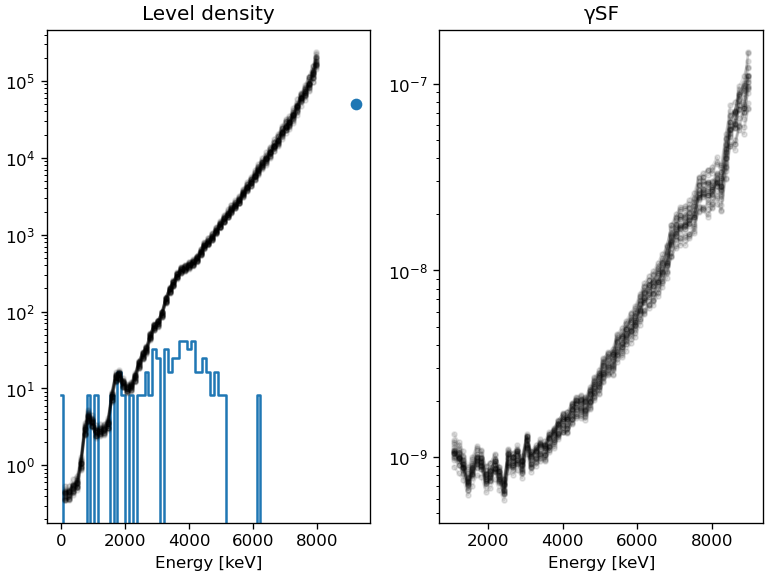

In [39]:
def plot_transformed(alpha, A=1, B=1):
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    discrete.to_keV()
    discrete.plot(ax=ax[0], kind='step')
    for nld, gsf in zip(extractor.nld, extractor.gsf):
        nld.transform(const=A, alpha=alpha, inplace=False).plot(ax=ax[0], scale="log", color='k', alpha=1/10)
        gsf.transform(const=B, alpha=alpha, inplace=False).plot(ax=ax[1], scale="log", color='k', alpha=1/10)
    ax[0].scatter([9.2184e3], [49712])
    ax[0].set_title("Level density")
    ax[1].set_title("γSF")

plot_transformed(A=0.2, alpha=shape.reg.coef_[0])

<IPython.core.display.Javascript object>


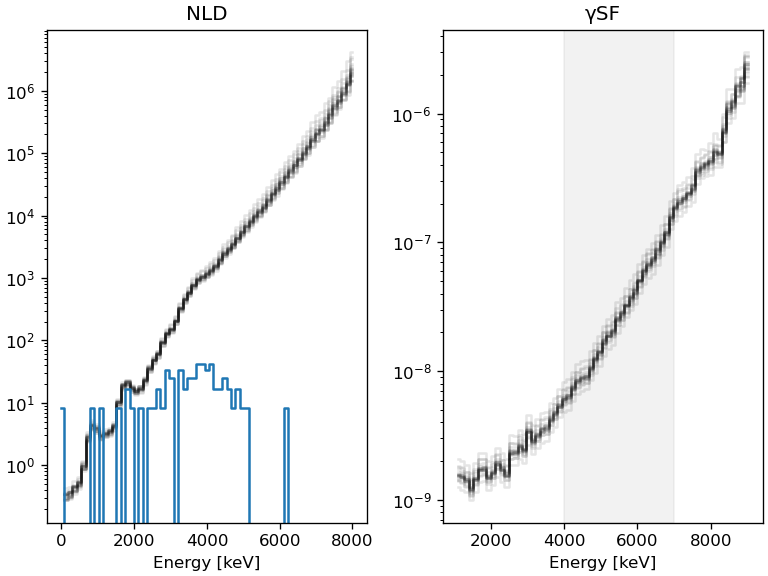

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f97f86ce160>)

In [85]:
extractor = om.Extractor(path="./saved_run/extraction_ensemble/")
alphas, (_, ax) = om.normalize_to_shape(extractor, shape, region=[4000, 7000])
discrete.plot(ax=ax[0], kind='step', scale='log')

In [86]:
alphas

[0.0016619486454019826,
 0.0016775721846795666,
 0.0016497250604311639,
 0.0016909142314006926,
 0.0016499491229344774,
 0.0017151804758406982,
 0.0016608474284562256,
 0.0016693548645719362,
 0.0017027196285612138,
 0.0016476293687771775,
 0.0017481307588054892,
 0.0016971317203739325,
 0.0016842673868947818,
 0.0016688527537319698,
 0.001658439242450486,
 0.0016925876151913505,
 0.0016720903061719734,
 0.0016674819282200533,
 0.0016978651495914495,
 0.0017067788107053734]